
 # Basic Multi-agent Collaboration

 A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

 One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

 This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.



The resulting graph will look something like the following diagram:

![multi_agent diagram](./img/simple_multi_agent_diagram.png)

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [1]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generates the response."""
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            # Ensure that params is passed as a dictionary
            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output."""
        combined_output = []
        for tool in tool_instances:
            result = tool.invoke(input_text)
            print("Result tool",result)
            #content = "WebSearch Results: " + " ".join(result['content'] for result in result)
            
            # Check if the result is a string, if so, use it directly
            if isinstance(result, str):
                content = "WebSearch Results: " + result
            # Otherwise, handle the case where it's a list of dictionaries (or similar structure)
            elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
            else:
                # Handle other unexpected cases (fallback)
                content = "WebSearch Results: Invalid format received from tool"
            


            combined_output.append(content)
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model."""
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)


def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

# Load environment variables
load_dotenv()

_set_env("TAVILY_API_KEY")
api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = _set_env("WATSONX_URL")

# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_instance = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters  # params passed as a dictionary
)

# Example usage
response = watsonx_instance.invoke("How is the weather in Genova")
print(response)


prompts ['How is the weather in Genova']
?The weather in Genoa is usually mild, with temperatures ranging from 15 to 26 degrees Celsius. The city is known for its Ligurian cuisine, which is based on vegetables, fruits, olive oil, and seafood. icing on the cake


In [2]:
# Example usage:
tool = TavilySearchResults(max_results=4)
llm_with_tools = watsonx_instance.bind_tools(tools=[tool],model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters)  
response = llm_with_tools.invoke("Who is Ruslan Magana?")
print(response) 

Result tool [{'url': 'https://ruslanmv.com/about', 'content': "I'm Ruslan Magana Vsevolodovna. I'm a Data Scientist, a Cloud Architect and a Physicist. About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track ..."}, {'url': 'https://scholar.google.com/citations?user=rWBrOpwAAAAJ', 'content': 'Ruslan Magana Vsevolodovna. National Institute for Nuclear Physics. Verified email at ge.infn.it - Homepage. Nuclear Physics Machine Learning Data Science Cloud Computing Big Data. ... R Magana, H Zheng, A Bonasera. International Journal of Modern Physics E 21 (01), 1250006, 2012. 4: 2012:'}, {'url': 'https://it.linkedin.com/in/ruslanmv', 'content': 'Consigliato da Ruslan Magana Vsevolodovna, PhD. I am an expert in Artificial Intelligence with a focus on Neural Networks. My primary expertise lies in Generativ

In [3]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

# Simplified loading of environment variables and IBM connection parameters
load_dotenv()

def set_env(var: str):
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

class IbmConnectionParams(BaseModel):
    api_key: str
    project_id: str
    url: str
    credentials: dict[str, str]

    def __init__(self, api_key: str, project_id: str, url: str) -> None:
        super().__init__(api_key=api_key, project_id=project_id, url=url, credentials={"url": url, "apikey": api_key})

# Set IBM connection parameters
ibm_params = IbmConnectionParams(
    api_key=set_env("WATSONX_API_KEY"),
    project_id=set_env("PROJECT_ID"),
    url = _set_env("WATSONX_URL")
)

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""
    
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        combined_output = []
        for tool in tool_instances:
            result = tool.invoke(input_text)
            print("Result tool", result)
            
            if isinstance(result, str):
                content = "WebSearch Results: " + result
            elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
            else:
                content = "WebSearch Results: Invalid format received from tool"

            combined_output.append(content)
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

# WatsonxLLM initialization with simplified parameters
watsonx_instance = WatsonxLLM(
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters
)



In [4]:
# Example usage
response = watsonx_instance.invoke("How is the weather in Genova")
print(response)


prompts ['How is the weather in Genova']
The weather in Genova is mild and rainy. Genoa is the capital of Liguria and is located on the west coast of the Italian Riviera. The climate is mild and rainy. The average temperature in Genoa in January is 8.4 degrees Celsius, while in July it is 26.1 degrees Celsius. The average annual rainfall is 1,115 mm.


In [4]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

# Simplified loading of environment variables and IBM connection parameters
load_dotenv()

def set_env(var: str):
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

class IbmConnectionParams(BaseModel):
    api_key: str
    project_id: str
    url: str
    credentials: dict[str, str]

    def __init__(self, api_key: str, project_id: str, url: str) -> None:
        super().__init__(api_key=api_key, project_id=project_id, url=url, credentials={"url": url, "apikey": api_key})

# Set IBM connection parameters
ibm_params = IbmConnectionParams(
    api_key=set_env("WATSONX_API_KEY"),
    project_id=set_env("PROJECT_ID"),
    url = _set_env("WATSONX_URL")
)

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""
    
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, model_id: Optional[str] = None, **kwargs):
        if not model_id and 'deployment_id' not in kwargs:
            raise ValueError("One of 'model_id' or 'deployment_id' parameters should be set.")
        super().__init__(model_id=model_id, *args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        combined_output = []
        for tool in tool_instances:
            result = tool.invoke(input_text)
            print("Result tool", result)
            
            if isinstance(result, str):
                content = "WebSearch Results: " + result
            elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
            else:
                content = "WebSearch Results: Invalid format received from tool"

            combined_output.append(content)
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

# WatsonxLLM initialization with simplified parameters
watsonx_instance = WatsonxLLM(
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters
)


In [5]:
# Example usage:
tool = TavilySearchResults(max_results=4)
llm_with_tools = watsonx_instance.bind_tools(tools=[tool],model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters)  
response = llm_with_tools.invoke("Who is Ruslan Magana?")
print(response) 

Result tool [{'url': 'https://ruslanmv.com/about', 'content': "I'm Ruslan Magana Vsevolodovna. I'm a Data Scientist, a Cloud Architect and a Physicist. About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track ..."}, {'url': 'https://scholar.google.com/citations?user=rWBrOpwAAAAJ', 'content': 'Ruslan Magana Vsevolodovna. National Institute for Nuclear Physics. Verified email at ge.infn.it - Homepage. Nuclear Physics Machine Learning Data Science Cloud Computing Big Data. ... R Magana, H Zheng, A Bonasera. International Journal of Modern Physics E 21 (01), 1250006, 2012. 4: 2012:'}, {'url': 'https://www.linkedin.com/posts/ruslanmv_watsonxgovernance-technical-sales-intermediate-activity-7192621868636323840-YmBn', 'content': 'Ruslan Magana Vsevolodovna, PhD Data Scientist 1mo Report this post 👋 Hello 

In [6]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

# Simplified loading of environment variables and IBM connection parameters
load_dotenv()

def set_env(var: str):
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

class IbmConnectionParams(BaseModel):
    api_key: str
    project_id: str
    url: str
    credentials: dict[str, str]

    def __init__(self, api_key: str, project_id: str, url: str) -> None:
        super().__init__(api_key=api_key, project_id=project_id, url=url, credentials={"url": url, "apikey": api_key})

# Set IBM connection parameters
ibm_params = IbmConnectionParams(
    api_key=set_env("WATSONX_API_KEY"),
    project_id=set_env("PROJECT_ID"),
    url = _set_env("WATSONX_URL")
)

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""
    # Define the default parameters as class variables
    DEFAULT_MODEL_ID = "ibm/granite-13b-instruct-v2"
    DEFAULT_URL = ibm_params.url
    DEFAULT_APIKEY = ibm_params.api_key
    DEFAULT_PROJECT_ID = ibm_params.project_id
    DEFAULT_PARAMS = parameters    
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, model_id: Optional[str] = None, **kwargs):
        if not model_id and 'deployment_id' not in kwargs:
            raise ValueError("One of 'model_id' or 'deployment_id' parameters should be set.")
        super().__init__(model_id=model_id, *args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        combined_output = []
        for tool in tool_instances:
            result = tool.invoke(input_text)
            print("Result tool", result)
            
            if isinstance(result, str):
                content = "WebSearch Results: " + result
            elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
            else:
                content = "WebSearch Results: Invalid format received from tool"

            combined_output.append(content)
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        model_id: Optional[str] = None,
        url: Optional[str] = None,
        apikey: Optional[str] = None,
        project_id: Optional[str] = None,
        params: Optional[Dict[str, Any]] = None,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        # Initialize WatsonxLLM with the provided parameters
        instance = cls(
            model_id=model_id,
            url=url,
            apikey=apikey,
            project_id=project_id,
            params=params,
            **kwargs
        )
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

# Example usage:
tool = TavilySearchResults(max_results=4)

# Bind the tool and pass all necessary parameters inside `bind_tools`
llm_with_tools = WatsonxLLM.bind_tools(
    tools=[tool],
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters
)

# Invoke the model
response = llm_with_tools.invoke("Who is Ruslan Magana?")
print(response)


Result tool [{'url': 'https://ruslanmv.com/about', 'content': "I'm Ruslan Magana Vsevolodovna. I'm a Data Scientist, a Cloud Architect and a Physicist. About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track ..."}, {'url': 'https://scholar.google.com/citations?user=rWBrOpwAAAAJ', 'content': 'Ruslan Magana Vsevolodovna. National Institute for Nuclear Physics. Verified email at ge.infn.it - Homepage. Nuclear Physics Machine Learning Data Science Cloud Computing Big Data. ... R Magana, H Zheng, A Bonasera. International Journal of Modern Physics E 21 (01), 1250006, 2012. 4: 2012:'}, {'url': 'https://it.linkedin.com/in/ruslanmv', 'content': 'Consigliato da Ruslan Magana Vsevolodovna, PhD. I am an expert in Artificial Intelligence with a focus on Neural Networks. My primary expertise lies in Generativ

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools,model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters)


In [8]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

In [9]:
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [10]:
# ## Create graph


import functools
from langchain_core.messages import AIMessage

In [11]:
# Helper function to create a node for a given agent
def agent_node_old(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

In [12]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Check if result has a dict method (indicating it's not a simple string)
    if hasattr(result, 'dict'):
        # If it's an object with a dict method, convert it to the appropriate format
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        # If result is a string, construct an AIMessage with the text
        result = AIMessage(content=str(result), name=name)
    
    return {
        "messages": [result],
        "sender": name,
    }


In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Research agent and node
research_agent = create_agent(
    watsonx_instance,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


In [15]:
# chart_generator
chart_agent = create_agent(
    watsonx_instance,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")


In [16]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [17]:
# ## Define Edge Logic

# %%
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

In [18]:
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [20]:
from langgraph.graph import END, StateGraph

In [21]:
# ## Define the Graph
# %%
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)


In [22]:
# Make sure the graph is initialized properly with a valid entry point

workflow.set_entry_point("Researcher")  # Set the entry point of the graph

# Compile the workflow to prepare it for execution
graph = workflow.compile()

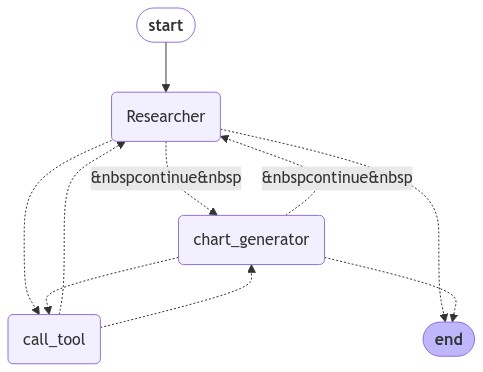

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [24]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)

In [25]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

Result tool HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')
prompts ["You are an assistant with access to web search results. Provide a detailed answer to the user's query.\n\nUser Query: System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You have access to the following tools: tavily_search_results_json.\nYou should provide accurate data for the chart_generator to use.\nHuman: Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish.\n\nUsing the information below:\nWeb Search Results: WebSearch Results: HTTPError('400 Client 